# Projet 7 : Implémentez un modèle de scoring

## Problématique

L'objectif est de développer un modèle de scoring de la probabilité de défaut de paiement d'un client pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, ...).

L'objectif de ce notebook :

* Traiter le problème de : 'Imbalanced Data'.
* Tester des différents modèles de classification en optimisant leurs hyperparamètres.
* Evaluer les performances des modèles en se basant sur des scores de classification.
* Construire une métrique Monétaire / Bancaire en pénalisant le défaut. 
* Optimiser le seuil de décision ( le seuil de solvabilité ).
* Sélectioner des caractéristiques de modèle (feature importance).


## Importation des modules

In [1]:
import numpy as np 
import pandas as pd

## PLOT
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

## Resampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from collections import Counter

##Split
from sklearn.model_selection import train_test_split

## Modelisation
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

## Scores
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_recall_fscore_support
import scikitplot as skplt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  make_scorer

## feature importance
import shap

## Threshold
from yellowbrick.classifier.threshold import discrimination_threshold

## Export
import pickle

## Warning
import warnings

In [2]:
warnings.filterwarnings("ignore")

##  Importation de données

In [3]:
dataset = pd.read_csv('df_final.csv')

In [4]:
dataset.shape

(307511, 47)

In [5]:
train_len = dataset.shape[0]

In [6]:
train_dataset = dataset[:train_len]
train_ids = train_dataset['SK_ID_CURR']
train_dataset.drop(columns=['SK_ID_CURR'], axis = 1, inplace=True)

* Définir les features et la variable cible pour la modélisation

In [7]:
# separate training data
train_dataset['TARGET'] = train_dataset['TARGET'].astype(int)
target = train_dataset['TARGET']
features = train_dataset.drop(columns=['TARGET'], axis = 1)
print('x_train data shape: ', features.shape)
print('y_train data shape: ', target.shape)

x_train data shape:  (307511, 45)
y_train data shape:  (307511,)
x_test data shape:  (0, 45)


In [8]:
target_sample = target
target_sample.shape

(307511,)

In [9]:
features_sample = features
features_sample.shape


(307511, 45)

* Le nombre des colonnes est : 45
* Le nombre des observations (lignes) est : 307511

## Preprocessing

Le prétraitement des données est le suivant:
* Fractionnement du jeu de données (40% test set).
* Définir les attributs (numériques , catégoriques ...)
* Compléter les données manquantes (Imputation):

Les variables numériques : Médiane (car variables asymétriques).
Les variables catégoriques : le plus fréquent.
* Mise à l'échelle des fonctionnalités (Robust scaler(plus fiable vis à vis des outliers)).
* Encodage des données catégorielles.


In [10]:
# Train test Split
X_train, X_test, y_train, y_test = train_test_split(features_sample, target_sample, test_size = 0.4)

In [11]:
# Define categorical columns
categoric_attribute = list(features_sample.select_dtypes(exclude=["number"]).columns)
# Define numerical columns
numeric_attribute = list(features_sample.select_dtypes(exclude=["bool_","object_"]).columns)


In [12]:
# Pipeline data transformation (Imputation / Scaling / Encoding):
def Preprocessing (numeric,categoric):
    numeric_transfs = [('imputer',SimpleImputer(missing_values= np.NAN, strategy= 'median')),('scaler', RobustScaler())]
    numeric_pipeline = Pipeline(numeric_transfs)
    categoric_transfs = [('imputer',SimpleImputer(strategy="most_frequent")),('encoding', OneHotEncoder(dtype=np.int,sparse=True,handle_unknown='ignore'))]
    categoric_pipeline = Pipeline(categoric_transfs)
    all_transfs = [("numeric",numeric_pipeline,numeric),("categorical",categoric_pipeline,categoric)]
    full_preprocessor = ColumnTransformer(all_transfs, remainder='passthrough')
    return full_preprocessor

In [13]:
# Data Transformed
preprocessor_fitted = Preprocessing(numeric_attribute,categoric_attribute).fit(X_train)
X_train_transformed = preprocessor_fitted.transform(X_train)
X_test_transformed = preprocessor_fitted.transform(X_test)

In [14]:
X_train_transformed.shape

(184506, 76)

In [15]:
X_test_transformed.shape

(123005, 76)

* Nombre des colonnes après encodage : 76
* Nombre des observations dans la fraction train : 184506
* Nombre des observations dans la fraction train : 123005

## Resampling

* Le sous-échantillonnage aléatoire (random undersampling) des observations majoritaires :  on retire aléatoirement des observations majoritaires
* Le sur-échantillonnage aléatoire (random oversampling) des observations minoritaires :  on tire au hasard des individus minoritaires que l’on rajoute aux données. 
* Le sur-échantillonnage synthétique (SMOTE pour Synthetic Minority Oversampling Technique) produit des observations minoritaires ressemblantes mais distinctes de celles déjà existantes.

L'idée est de combiner SMOTE avec une technique de sous-échantillonnage (ENN, Tomek) pour augmenter l'efficacité de la gestion de la classe déséquilibrée.

In [16]:
# define smote strategy
sm = SMOTE(random_state=42)
# Define SMOTE-Tomek Links (Over-sampling followed by under-sampling)
smtomek=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

In [17]:
def resampling (features, target, resample):
    print('Original dataset shape %s' % Counter(target))
    X, y = resample.fit_resample(features, target)
    print('Resampled dataset shape %s' % Counter(y))
    return X, y

In [212]:
# X_train_sm,y_train_sm = resampling (X_train_transformed, y_train, sm)

Original dataset shape Counter({0: 5513, 1: 487})
Resampled dataset shape Counter({0: 5513, 1: 5513})


In [18]:
X_train_smtomek,y_train_smtomek = resampling (X_train_transformed, y_train, smtomek)

Original dataset shape Counter({0: 169614, 1: 14892})
Resampled dataset shape Counter({1: 169614, 0: 166231})


In [19]:
X_test_smtomek,y_test_smtomek = resampling (X_test_transformed, y_test, smtomek)

Original dataset shape Counter({0: 113072, 1: 9933})
Resampled dataset shape Counter({1: 113072, 0: 110552})


In [21]:

pd.DataFrame(X_train_smtomek).to_csv('X_train_smtomek.csv',index=False)
pd.DataFrame(y_train_smtomek).to_csv('y_train_smtomek.csv',index=False)
pd.DataFrame(X_test_smtomek).to_csv('X_test_smtomek.csv',index=False)
pd.DataFrame(y_test_smtomek).to_csv('y_test_smtomek.csv',index=False)

## Models optimisation

Le but de cette partie est de trouver l'ensemble d'arguments de configuration de modèle spécifiques qui entraînent les meilleures performances du modèle .

La méthode d'optimisation des hyperparamètres est basée sur GRID SEARCH CV.

Les modèles de classification à tester sont : 
Random Foresr Classifier & LightGBM classifier.

### Métrique Spécifique

La métrique Bancaire consiste à calculer le gain obtenu pour l'ensemble des individus du jeu de données.
Pour cela, on va pénaliser le défaut (avec un gros poids correspondant aux potentiel pertes en capital) et bonifier un remboursement (faible poids correspondant aux intérêts générés). 
Les valeurs des poids sont les suivantes :

- fn_value = -2
- tp_value = 0
- tn_value = 1
- fp_value = -0.5

Les poids sont arbitraires et il est tout à fait possible de changer ces valeurs à la convenance de l'optique métier. 

In [22]:
def bank_score(y_true, y_pred, fn_value=-2, fp_value=-0.5, tp_value=0, tn_value=1):

    # Matrice de Confusion
    mat_conf = confusion_matrix(y_true,y_pred)
    
    tn = mat_conf[0, 0]
    fn = mat_conf[1, 0]
    fp = mat_conf[0, 1]
    tp = mat_conf[1, 1]
    
    
    Gain_tot = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    G_max = (fp + tn)*tn_value + (fn + tp)*tp_value
    G_min = (fp + tn)*fp_value + (fn + tp)*fn_value
    
    G_normalized = (Gain_tot - G_min)/(G_max - G_min)
    
    return G_normalized  

### Optimisation des hyperparamétres des modèles de classification

Les modèles de classification à optimiser : 

***Random Forest : 

- (n_estimators) Le nombre d'arbres  
- (max_depth) La profondeur maximale de l'arbre 
- (criterions) La fonction pour mesurer la qualité d'un split. « gini » pour l'impureté de Gini et « entropie » pour le gain d'informations. 

***Lightgbm : 

- (max_depth) :  contrôle la distance maximale entre le nœud racine de chaque arbre et un nœud feuille. Diminuer max_depth réduit le temps d'entraînement. 
- (num_leaves):  définit le nombre maximal de nœuds par arbre. Diminuer num_leaves réduit le temps de entraînement.

In [19]:
def model_optimisation (classifier, param_grid, scoring, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid,scoring=scoring, cv=cv)
    grid_search.fit(X, y)
    return grid_search.best_score_,grid_search.best_params_,grid_search.best_estimator_
    

In [122]:
### Random forest
n_estimators = [140,150,160]
max_depth = range(2,5)
criterions = ['gini', 'entropy']
rf_parameters = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'criterion': criterions}
RFC = RandomForestClassifier(max_features='auto')
scorers = {
    'roc_auc':'roc_auc',
    'bank_score': make_scorer(bank_score)
}

In [132]:
### Light GBM
light_gbm_params = {
        'max_depth': (6, 10),
        'num_leaves':(15, 20),
        #'min_data_in_leaf': (230, 250),
               }
#score = 'precision_recall_fscore_support'
LGBM = lgb.LGBMClassifier(random_state=0, n_estimators=3000)
scorers = {
    'roc_auc':'roc_auc',
    'bank_score': make_scorer(bank_score)
}

#### Optimisation de Random Forest

In [125]:
rf_model_score,rf_model_param,rf_model_estimator = model_optimisation (RFC, rf_parameters, score, X_train_smtomek, y_train_smtomek)

In [126]:
rf_model_score

0.9696324393561259

In [127]:
rf_model_estimator

RandomForestClassifier(max_depth=4, n_estimators=160)

#### Optimisation de light gbm

In [133]:
lgbm_model_score,lgbm_model_param,lgbm_model_estimator = model_optimisation (LGBM, light_gbm_params, score, X_train_smtomek, y_train_smtomek)

In [134]:
lgbm_model_score

0.9892851549594083

In [135]:
lgbm_model_estimator

LGBMClassifier(max_depth=10, n_estimators=3000, num_leaves=20, random_state=0)

##### Conclusion :

En se basant sur l'optimisation de grid search cv, par rapport au scores : [ROC AUC et Métrique bancaire], les modèles retenus sont les suivants :
* RandomForestClassifier(max_depth=4, n_estimators=160)
* LGBMClassifier(max_depth=10, n_estimators=3000, num_leaves=20, random_state=0)

## Entrainement du modèle optimal

In [23]:
rf_model_estimator = RandomForestClassifier(max_depth=4, n_estimators=160)

In [24]:
lgbm_model_estimator = lgb.LGBMClassifier(max_depth=10, n_estimators=3000, num_leaves=20, random_state=0)

In [25]:
def model_trained (best_classifier, X, y):
    clf = best_classifier.fit(X,y)
    best_score = best_classifier.score(X,y)
    return clf,best_score    

In [26]:
rf_model,rf_score = model_trained (rf_model_estimator, X_train_smtomek, y_train_smtomek)

In [27]:
rf_score

0.8306599770727567

In [28]:
lgbm_model,lgbm_score = model_trained (lgbm_model_estimator, X_train_smtomek, y_train_smtomek)

In [29]:
lgbm_score

0.9764236478137236

* le score du random forest sur les données d'entrainement est : 0.83
* le score du lightgbm sur les données d'entrainement est : 0.97

## Prediction 

In [30]:
def prediction (clf,X,y):
    y_pred=clf.predict(X)
    y_prob = clf.predict_proba(X)
    print('Test set score: {:.4f}'.format(clf.score(X, y)))
    #auc_score = roc_auc_score(y, y_prob[:,1])
    #print('Test auc score :', auc_score)
    return y_pred,y_prob

#### Résultat de Prediction de Random Forest

In [32]:

y_predicted_rf, y_probability_rf  = prediction (rf_model,X_test_smtomek,y_test_smtomek)

Test set score: 0.8363


#### Résultat de Prediction de Lightgbm

In [33]:
y_predicted_lgbm, y_probability_lgbm  = prediction (lgbm_model,X_test_smtomek,y_test_smtomek)

Test set score: 0.9541


### Export data to dashbord

In [69]:
# save the model to disk
filename = 'classifier_rf_model.sav'
pickle.dump(rf_model, open(filename, 'wb'))

In [70]:
# save the model to disk
filename = 'classifier_lgbm_model.sav'
pickle.dump(lgbm_model, open(filename, 'wb'))

In [78]:
# save the preprocessor to disk
filename = 'preprocessor.sav'
pickle.dump(preprocessor_fitted, open(filename, 'wb'))

In [71]:
df_transformed = preprocessor_fitted.transform (train_dataset.iloc[0:10000].drop(columns=['TARGET'], axis = 1))

In [74]:
#y_predicted, y_probability  = prediction (rf_model,df_transformed,train_dataset.iloc[0:10000]['TARGET'])
#data_export = train_dataset.iloc[0:10000].copy()
#data_export['SK_ID_CURR']=train_ids[0:10000]
#data_export['prediction']=y_predicted_rf
#data_export['pred_prob']=y_probability_rf[:,1]

In [67]:
data_export.to_csv("dataset_exported.csv",index=False)

In [45]:
y_pred_test_export = pd.DataFrame()
y_pred_test_export['y_test'] = y_test
y_pred_test_export['y_probability'] = y_probability_rf[:,1]
y_pred_test_export['y_predicted'] = y_predicted_rf
y_pred_test_export.to_csv("y_pred_test_export.csv",index=False)


## Scores

### seuil de discrimination

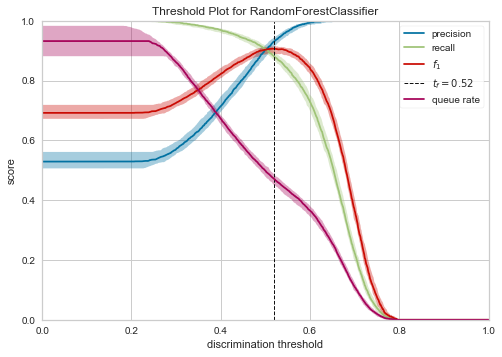

dict_keys(['argmax', 'ax', 'cv', 'estimator', 'exclude', 'fbeta', 'force_model', 'is_fitted', 'n_trials', 'quantiles', 'random_state']) 


dict_keys(['argmax', 'ax', 'cv', 'estimator', 'exclude', 'fbeta', 'force_model', 'is_fitted', 'n_trials', 'quantiles', 'random_state']) 




DiscriminationThreshold(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002D9B98ADA30>,
                        estimator=RandomForestClassifier(criterion='entropy',
                                                         max_depth=4,
                                                         n_estimators=140),
                        force_model=None)

In [31]:
discrimination_threshold(model, X_train, y_train)

### matrice de confusion 

La matrice de confusion permet d'évaluer l'exactitude d'une classification.

Les individus dont la valeur cible réelle est 0 et dont la prédiction est 0 sont les 'True Negatives' dits aussi 'TN'

Les individus dont la valeur cible réelle est 0 alors que la prédiction est 1 sont les 'False Negatives' appelés aussi 'FN'

Les individus dont la valeur cible réelle est 1 alors que la prédiction est 0 sont les 'False Positives' appelés aussi 'FP'

Les individus dont la valeur cible réelle est 1 et dont la prédiction est 1 sont les 'True Positives' appelés aussi 'TP'

In [34]:
def matrix_confusion (X,y):
    cm = confusion_matrix(X, y)
    print('\nTrue Positives(TP) = ', cm[0,0])
    print('\nTrue Negatives(TN) = ', cm[1,1])
    print('\nFalse Positives(FP) = ', cm[0,1])
    print('\nFalse Negatives(FN) = ', cm[1,0])
    return  cm

In [35]:
# visualize confusion matrix with seaborn heatmap
def plot_matrx_confusion (data):
    cm_matrix = pd.DataFrame(data, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                     index=['Predict Positive:1', 'Predict Negative:0'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

#### Matrice de confusion de random Forest


True Positives(TP) =  92952

True Negatives(TN) =  94054

False Positives(FP) =  17600

False Negatives(FN) =  19018


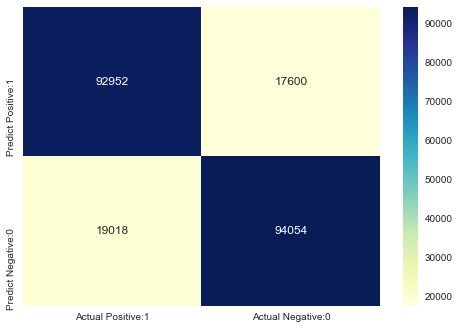

In [36]:
plot_matrx_confusion (matrix_confusion(y_test_smtomek,y_predicted_rf))

#### Matrice de confusion de LightGBM


True Positives(TP) =  110165

True Negatives(TN) =  103196

False Positives(FP) =  387

False Negatives(FN) =  9876


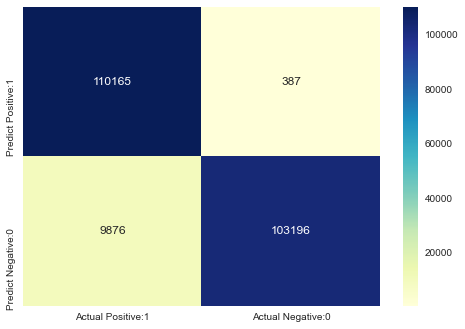

In [37]:
plot_matrx_confusion (matrix_confusion(y_test_smtomek,y_predicted_lgbm))

La matrice de confusion résume le nombre de prédictions faites par chaque modèle pour chaque classe, et les classes auxquelles ces prédictions appartiennent réellement. 
* Pour le random Forest : 84 % des prédictions positives sont vraies et 83 % des prédictions négatives sont vraies.
* Pour le Lightgbm : 91 % des prédictions positives sont vraies et 99 % des prédictions négatives sont vraies.


### Roc curve

le Roc curve résume les performances d'un classificateur sur tous les seuils possibles. Il est généré en traçant le taux de vrais positifs (axe des y) par rapport au taux de faux positifs (axe des x).

In [38]:
import scikitplot as skplt
from sklearn.metrics import roc_curve

#### Roc curve pour Random Forest

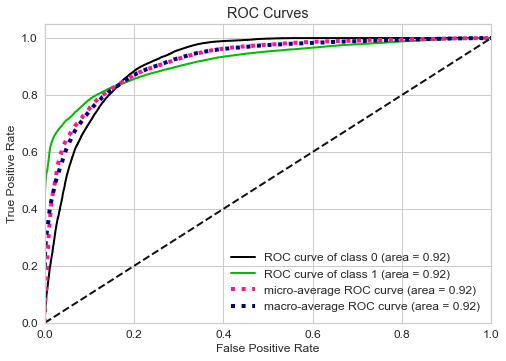

In [39]:
skplt.metrics.plot_roc_curve(y_test_smtomek, y_probability_rf)
plt.show()

#### Roc curve pourLightgbm

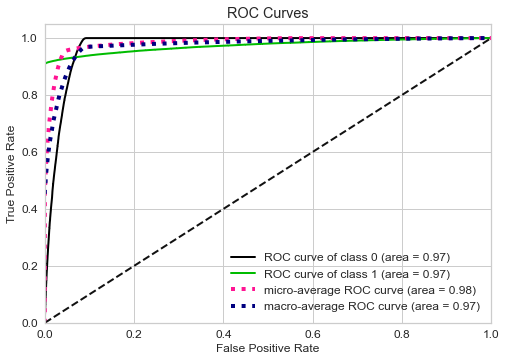

In [40]:
skplt.metrics.plot_roc_curve(y_test_smtomek, y_probability_lgbm)
plt.show()

La courbe ROC montre le compromis entre la sensibilité (ou TPR) et la spécificité (1 – FPR). Les classificateurs qui donnent des courbes plus proches du coin supérieur gauche indiquent une meilleure performance. 
* Le lgbm indique donc une meilleure performance.

### metrique bancaire

La métrique Bancaire consiste à calculer le gain obtenu pour l'ensemble des individus du jeu de données. Pour cela, on va pénaliser le défaut (avec un gros poids correspondant aux potentiel pertes en capital) et bonifier un remboursement (faible poids correspondant aux intérêts générés). Les valeurs des poids sont les suivantes :

fn_value = -2
tp_value = 0
tn_value = 1
fp_value = -0.5


In [41]:
bank_score(y_test_smtomek, y_predicted_rf, fn_value=-2, fp_value=-0.5, tp_value=0, tn_value=1)

0.8356107068872266

In [42]:
bank_score(y_test_smtomek, y_predicted_lgbm, fn_value=-2, fp_value=-0.5, tp_value=0, tn_value=1)

0.9481276723847621

In [43]:
bank_scorer=make_scorer(bank_score, fn_value=-2, fp_value=-0.5, tp_value=0, tn_value=1, greater_is_better=True)

### FBeta score

La mesure Fbeta est une métrique à score unique configurable pour évaluer un modèle de classification binaire basé sur les prédictions faites pour la classe positive.

Elle est calculée en utilisant la précision et le rappel.

La précision est une métrique qui calcule le pourcentage de prédictions correctes pour la classe positive. Le Recall calcule le pourcentage de prédictions correctes pour la classe positive parmi toutes les prédictions positives qui pourraient être faites. Maximiser la précision minimisera les erreurs de faux positifs, tandis que maximiser le rappel minimisera les erreurs de faux négatifs.

La mesure Fbeta est une généralisation de la mesure F qui ajoute un paramètre de configuration appelé bêta. Une valeur bêta par défaut est 1,0, ce qui est identique à la F-mesure. Une valeur bêta plus petite, telle que 0,5, donne plus de poids à la précision et moins au rappel, tandis qu'une valeur bêta plus élevée, telle que 2,0, donne moins de poids à la précision et plus de poids au rappel dans le calcul du score.

Dans notre cas, on s'interesse à maximiser le rappeldonc minimiser les erreurs de faux négatifs.==> beta=2


In [44]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)

### Seuil solvabilité optimal

Ce problème de classification présente un déséquilibre de classe. 
Donc,le seuil par défaut peut entraîner de mauvaises performances.
Pour améliorer les performances d'un modèle  qui prédit les probabilités sur un problème de classification déséquilibré, on va régler le seuil utilisé pour mapper les probabilités aux étiquettes de classe.

In [45]:
def seuil_optimal_search(y_true,y_prob,score_function):
    thresholds = np.linspace(0.0, 1, 30)
    scores_thresholds = []
    
    for th in thresholds:
            y_pred = (y_prob[:,1]>th)*1
            scores_thresholds.append(score_function(y_true,y_pred))
    # Plot  
    plt.plot(thresholds, scores_thresholds)
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Indice banquaire")
    plt.xticks(np.linspace(0.1, 1, 10))
    
    idx_best_th = scores_thresholds.index(max(scores_thresholds))
    return thresholds[idx_best_th]

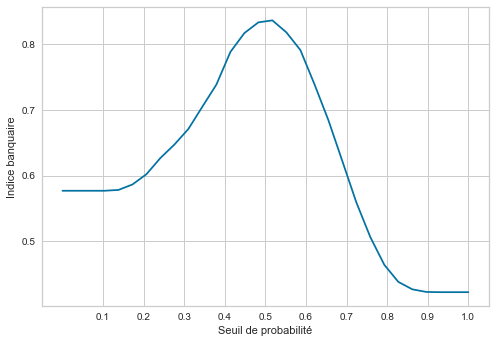

In [46]:
seuil_optim_rf =seuil_optimal_search(y_test_smtomek,y_probability_rf,bank_score)

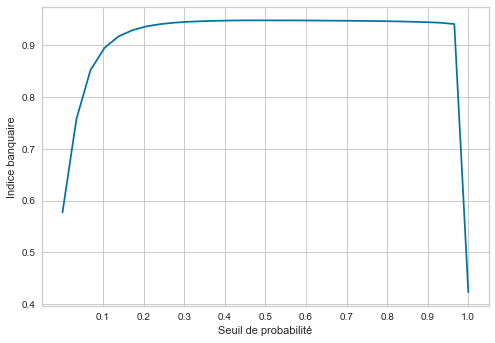

In [47]:
seuil_optim_lgbm =seuil_optimal_search(y_test_smtomek,y_probability_lgbm,bank_score)

In [76]:
seuil_optim_rf

0.5172413793103449

In [77]:
seuil_optim_lgbm

0.48275862068965514

In [48]:
y_pred_rf_th_optim = (y_probability_rf[:,1]>seuil_optim_rf)*1
y_pred_lgbm_th_optim = (y_probability_lgbm[:,1]>seuil_optim_lgbm)*1

* Le seuil optimal pour le modèle random Forest est : 0.52
* Le seuil optimal pour le modèle Lightgbm est : 0.48

## Evaluation modèle par rapport au seuil de solvabilité

Dans cette partie, on va évaluer les performances des deux modèles de classification optimisés et entrainés (RF et Lgbm) par rapport aux différentes métriques de scoring en utilisant le seuil de solvabilité optimal.

In [49]:
def eval_model(model,X,y,scoring):
    score = cross_val_score(model, X, y, scoring=scoring,cv=3)
    score_moy = score.mean()
    return score_moy

In [50]:
fbeta_score(y_test_smtomek,y_pred_rf_th_optim, beta=2)

0.8132301186200735

In [51]:
scoring_metrics = ['roc_auc',bank_scorer,ftwo_scorer]

In [52]:
rf_model_scores =[]
for metric in scoring_metrics:
    score = eval_model(rf_model,X_test_smtomek,y_test_smtomek,metric)
    rf_model_scores.append(score)
    print('score : ' ,score)

score :  0.9095755692214404
score :  0.8200192750881522
score :  0.8193893169355505


In [53]:
rf_model_scores_thresh_optim =[]

rf_model_scores_thresh_optim.append(roc_auc_score(y_test_smtomek,y_pred_rf_th_optim))
rf_model_scores_thresh_optim.append(bank_score(y_test_smtomek,y_pred_rf_th_optim))
rf_model_scores_thresh_optim.append(fbeta_score(y_test_smtomek,y_pred_rf_th_optim,beta=2))

In [54]:
lgbm_model_scores =[]
for metric in scoring_metrics:
    score = eval_model(lgbm_model,X_test_smtomek,y_test_smtomek,metric)
    lgbm_model_scores.append(score)
    print('score : ' ,score)

score :  0.9633553507929892
score :  0.9459276979551831
score :  0.9239641132222222


In [55]:
lgbm_model_scores_thresh_optim =[]

lgbm_model_scores_thresh_optim.append(roc_auc_score(y_test_smtomek,y_pred_lgbm_th_optim))
lgbm_model_scores_thresh_optim.append(bank_score(y_test_smtomek,y_pred_lgbm_th_optim))
lgbm_model_scores_thresh_optim.append(fbeta_score(y_test_smtomek,y_pred_lgbm_th_optim,beta=2))

In [56]:
df_scores= pd.DataFrame( {'metrics': ['roc_auc','bank_score','f_beta']})

In [57]:
df_scores['rf_scores']=rf_model_scores

In [58]:
df_scores['lgbm_scores']=lgbm_model_scores

In [59]:
df_scores['rf_scores_thresh_optim']=rf_model_scores_thresh_optim

In [60]:
df_scores['lgbm_scores_thresh_optim']=lgbm_model_scores_thresh_optim

In [61]:
df_scores

,metrics,rf_scores,lgbm_scores,rf_scores_thresh_optim,lgbm_scores_thresh_optim
0,roc_auc,0.909576,0.963355,0.842216,0.954524
1,bank_score,0.820019,0.945928,0.835511,0.948140
2,f_beta,0.819389,0.923964,0.813230,0.928462


In [62]:
df = pd.melt(df_scores, id_vars="metrics", var_name="model", value_name="scores")

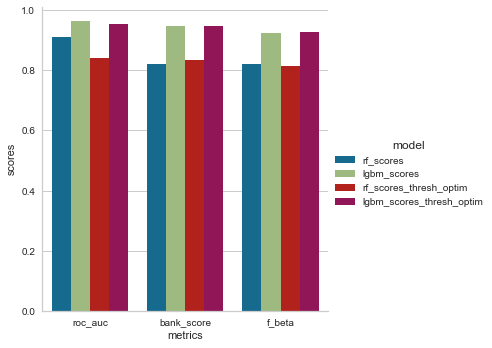

In [63]:
sns.factorplot(x='metrics', y='scores', hue='model', data=df, kind='bar')

### Conclusion :

En comparant les performances de deux modèles de classification, on trouve que le Lightgbm est plus performant suivants les différents scores comme la métrique bancaire, le roc et la fbeta.

Les modèles de boosting (lgbm) sont plus sujets au surentrainement. Ils offrent une précision beaucoup plus élevée et sont plus comptabiles avec les grands ensembles de données .

On remarque que le seuil de solvabilité permet d'ajuster les scores de roc et fbeta pour les deux modèles. Contrairement au score bancaire qui augmente pour les deux modèles en appliquant ce seuil de solvabilité.


## Feature importance 

In [79]:
def important_feature_df (classifier, X) :
    X_importance = X
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_importance)
    vals= np.abs(shap_values).mean(0)
    x = pd.DataFrame(X)
    feature_importance = pd.DataFrame(list(zip(x.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
    return feature_importance

In [80]:
def feature_importance_graphic(classifier, X):
    X_importance = X
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_importance)
    shap.summary_plot(shap_values[1], X_importance)
    shap.summary_plot(shap_values, X_importance, plot_type='bar')
    #shap.force_plot(explainer.expected_value[1], shap_values[1], X)
    return 

In [ ]:
#!!!!! debug
df_impor_feature=important_feature_df(model, features_sample)

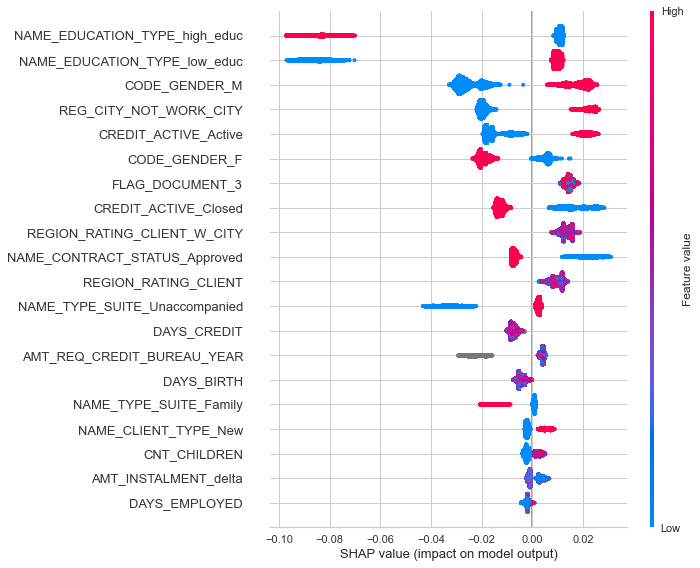

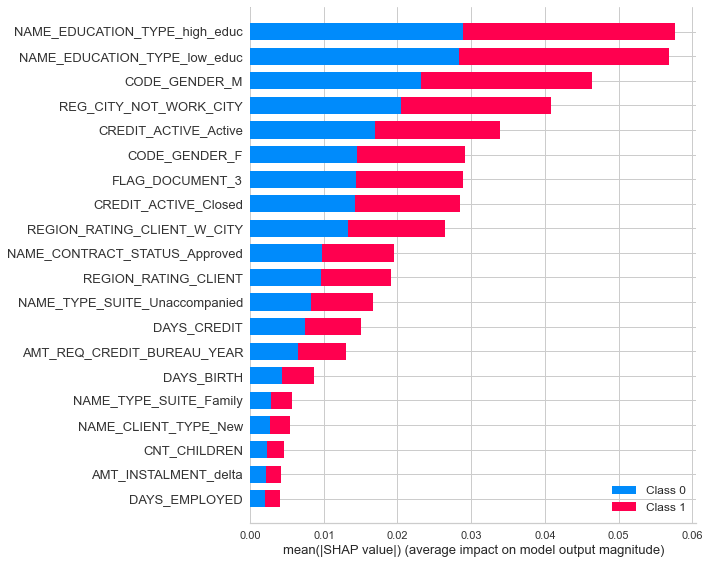

In [81]:
feature_importance_graphic(rf_model, pd.get_dummies(features_sample))

In [ ]:
feature_importance_graphic(lgbm_model,pd.get_dummies(features_sample))